In [197]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os 
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import torch
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle

In [198]:
cur_dir=os.getcwd()
print(cur_dir)
data=pd.read_csv("Dataset.csv", encoding='latin-1')

D:\Data Science Projects\dataScienceProjects-spamSmsDetector


# EDA

In [199]:
data.head()

,Message,Type
0,"Go until jurong point, crazy.. Available only ...",non-spam
1,Ok lar... Joking wif u oni...,non-spam
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,non-spam
4,"Nah I don't think he goes to usf, he lives aro...",non-spam


In [65]:
data.shape

(5572, 2)

In [115]:
data['Type'].value_counts()

non-spam    4825
spam         747
Name: Type, dtype: int64

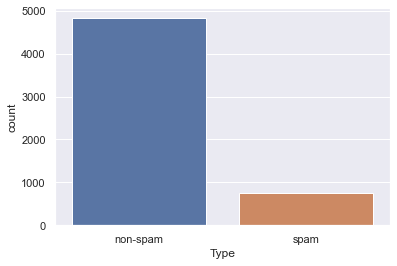

In [116]:
sns.set_theme(style="darkgrid")
ax = sns.countplot( x='Type',data=data)

In [117]:
data.isnull().sum()

Message    0
Type       0
dtype: int64

Text(0.5, 1.0, 'Distribution of word length in Non-Spam messages')

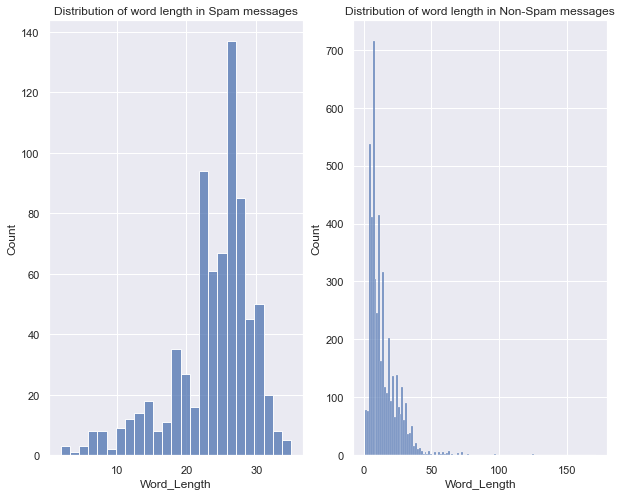

In [69]:
data['Word_Length']=data['Message'].apply(lambda x: len(x.split(" ")))
data_spam=data.loc[data['Type']=='spam']
data_nonSpam=data.loc[data['Type']=='non-spam']
sns.set()
fig,axes=plt.subplots(1,2,figsize=(10,8))
sns.histplot(ax=axes[0],data=data_spam,x='Word_Length')
axes[0].set_title('Distribution of word length in Spam messages')
sns.histplot(data=data_nonSpam,x='Word_Length',ax=axes[1])
axes[1].set_title('Distribution of word length in Non-Spam messages')

Above distibution shows that the word lengths of spam messages are higher compared to the word length of the non-spam messages.

Two types of currency has been used extensively in the text data pounds (£) and dollar ($). This Currency symbol may be somehow related to the spam message. Let us check currency symbol distribution in the messages.

In [118]:
def check_text_contains_currency(document):
    #Since there are only two currency symbols in the document
    if '$' in document or '£' in document: 
        return 1
    else:
        return 0
data['Currency_symbol']=data['Message'].apply(check_text_contains_currency)

In [119]:
#spam data with currency
data_spam=data.loc[data['Type']=='spam']
data_spam_dist=data_spam['Currency_symbol'].value_counts()
data_spam_dist

0    490
1    257
Name: Currency_symbol, dtype: int64

In [120]:
Spamdata_withSymb_per=round((data_spam_dist[1]/(data_spam_dist[0]+data_spam_dist[1]))*100,2)
Spamdata_withSymb_per

34.4

In [121]:
data_nonSpam=data.loc[data['Type']=='non-spam']
data_nonspam_dist=data_nonSpam['Currency_symbol'].value_counts()
data_nonspam_dist

0    4807
1      18
Name: Currency_symbol, dtype: int64

In [122]:
NonSpamdata_withSymb_per=round((data_nonspam_dist[1]/(data_nonspam_dist[0]+data_nonspam_dist[1]))*100,2)
NonSpamdata_withSymb_per

0.37

More than one-third of spam messages have currency symbols in it wheras just one percent of non-spam message have any currency symbol in it. It can be an important feature for model. Hence I will keep ***Currency_symbol*** as one of the feature for the training of model.

## Data Cleaning and Pre-processing

In [178]:
  
    
def cleanDocument(document):  
    '''This function performs some cleaning operations such as removing number, extra spaces etc. to text data'''
    # Changing the text to lowercase
    document=document.lower()

    #Removing extra spaces
    document=re.sub(r' +',' ',document)

    #Removing Punctuality
    exclude = set(string.punctuation)
    document = ''.join(ch for ch in document if ch not in exclude)

    #Removing numbers
    document=document.strip()
    document=re.sub(r'\d+','',document)

    #Removing Stop words
    selected_words=[]
    stop_words=list(stopwords.words("english"))
    tokens=word_tokenize(document)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            selected_words.append(tokens[i])    
    return " ".join(selected_words)

# Function for lemmetization
def lemmetize(document): 
    ''' This function does lemmetizaton of doucument'''
    lem=WordNetLemmatizer()
    tokens=word_tokenize(document)
    for i in range(len(tokens)):
        lem_word=lem.lemmatize(tokens[i])
        tokens[i]=lem_word

    document=" ".join(tokens)
    return document

# # Encoding of label
# def label_encoder(labels):
#     '''This function performs label encoding'''
#     le=preprocessing.LabelEncoder()
#     le.fit(labels)
#     return le.transform(labels)
    
        


In [124]:
data['Message']=data['Message'].apply(lambda x: cleanDocument(x))

In [125]:
data['Message']=data['Message'].apply(lambda x: lemmetize(x))

In [126]:
data['Message'].head()

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: Message, dtype: object

In [200]:
le=preprocessing.LabelEncoder()
data['Type']=le.fit_transform(data['Type'])
# le.transform(labels)
data['Type']

# print(data['Type'])

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Type, Length: 5572, dtype: int32

### Approach <br>
Data is highly Imbalanced, and needs to be balanced for better classification. My approach is to use deep learning to augment minority class data in the training set and then use TFIDF vecorizer to vectorize document.

***Note :*** <br>
I could have first converted all the the dataset to numerical values using vectorization technique such as TFIDF and then could have used SMOTE for balancing the dataset of the training data. But, data after tfidf vectorization dataset will have high dimension and SMOTE doesn't perform good with high dimesional dataset. 



### Train/Test/Validation split

In [128]:
X=data['Message']
y=data['Type']

In [129]:
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [130]:
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, test_size=0.30, random_state=42)

In [131]:
X_train.shape

(2730,)

In [132]:
X_test.shape

(1672,)

In [133]:
X_val.shape

(1170,)

In [134]:
y_test.shape

(1672,)

In [135]:
y_train.shape

(2730,)

In [136]:
y_val.shape

(1170,)

Balancing data in the training set using deep learning augmentation technique

In [137]:
import nlpaug.augmenter.word.context_word_embs as aug

In [138]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
augmenter.augment('This is a cow')

'so this is a desert cow'

Function to generate augmented data

In [139]:
def augmentMinorityClassData(X_train, augmenter):
    '''This function augment text data belonging to the minority to a new dataframe and return the same'''
    X_train_spam=training_data.loc[training_data['Type']==1]
    val=training_data['Type'].value_counts()
    min_maj_diff=val[0]-val[1]
#     min_maj_diff
    augmentedDocuments=[]
 # tqdm package is used to see the progress of for loop
    for i in tqdm(np.random.randint(0,len(X_train_spam),size=min_maj_diff)):
        '''For loop randomly chooses a text from the minority class to augment and appends 
        augmented text to list variable named augmentedDocuments'''
        document = X_train_spam['Message'].iloc[i]
#         print(document)
        augmented_document = augmenter.augment(document)
        augmentedDocuments.append(augmented_document)
        
    new=pd.DataFrame({'Message':augmentedDocuments,'Type':1})
    # Suffling the data in the created dataframe
    X_train=shuffle(X_train.append(new).reset_index(drop=True))
    return X_train
        
    

In [140]:
# Passing the Message, augmenter object, and minority and majority difference 
training_data=pd.concat([X_train,y_train],axis=1)
training_data['Type'].value_counts()

0    2353
1     377
Name: Type, dtype: int64

In [101]:
aug_df=augmentMinorityClassData(training_data,augmenter)

  0%|          | 0/1976 [00:00<?, ?it/s]

In [141]:
aug_df['Type'].value_counts()

1    2353
0    2353
Name: Type, dtype: int64

Data of each type in the training set after balancing

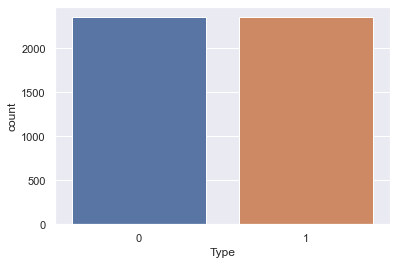

In [142]:
sns.set_theme(style="darkgrid")
ax = sns.countplot( x='Type',data=aug_df)

In [154]:
training_data_aug=aug_df
y_train=training_data_aug['Type']

### Converting documents to vector using tfidf vectorizer

In [159]:
corpus=[]
for document in training_data_aug['Message']:
    corpus.append(document)
tfidf = TfidfVectorizer(max_features=450)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names() 
train_X_tfidf = pd.DataFrame(vectors, columns=feature_names)


In [149]:
train_X_tfidf.head()

,100,access,account,age,all,already,also,amp,ampm,an,...,xxx,ya,yeah,year,yes,you,your,youre,yr,ìï
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.357563,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.320997,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
nb = GaussianNB()
nb.fit(train_X_tfidf, y_train)

GaussianNB()

In [ ]:
# Transforming the validation data using tfidf object fitted with the training data

In [160]:
vectors=tfidf.transform(X_val).toarray()
val_X_tfidf = pd.DataFrame(vectors, columns=feature_names)

In [162]:
y_preds = nb.predict(val_X_tfidf)

In [166]:
print(confusion_matrix(y_val, y_preds))
print(accuracy_score(y_val, y_preds))
print(classification_report(y_val, y_preds))

[[997  22]
 [ 26 125]]
0.958974358974359
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1019
           1       0.85      0.83      0.84       151

    accuracy                           0.96      1170
   macro avg       0.91      0.90      0.91      1170
weighted avg       0.96      0.96      0.96      1170



Parameter Tunning

In [169]:

def predict_sms_categ(message,nb):
    message=cleanDocument(message)
    message=lemmetize(message)
    message=tfidf.transform([message]).toarray()
    pred=nb.predict(message)    
    return pred
    
    

In [174]:
pred=predict_sms_categ('IMPORTANT - You could be entitled up to £3,160 in compensation from mis-sold PPI on a credit card or loan. Please reply',nb)
if pred==1:
    print('This is a spam SMS')
else:
    print('This is normal SMS')

This is a spam SMS


In [177]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(nb,open('nb.pkl','wb'))


In [201]:
pickle.dump(le,open('le.pkl','wb'))

In [187]:
le=pickle.load(open('le.pkl','rb'))

In [189]:
message=cleanDocument("THis asdjf asdfasdf")
message=lemmetize(message)
message=tfidf.transform([message]).toarray()
pred=nb.predict(message) 


In [202]:
x=le.inverse_transform(pred)


In [203]:
x

array(['non-spam'], dtype=object)